In [3]:
# Import the required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
import itertools
import hssm

In [4]:
#Set up plotting themes
sns.set_context('poster')
sns.set_style('darkgrid')

In [5]:
data = pd.read_csv('source_mem_data/24068_eb_mem0_2010-10-29_23h54.25.744.csv')

# Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
# data = data.dropna(subset=['trials.thisRepN']).reset_index(drop=True)

#If data file is incomplete, raise an error. 
#Label conditions based on participant number as was designed in the experiment
if data['participant'][0]%2 == 0:
    data['condition'] = 'structured'
else:
    data['condition'] = 'unstructured'


In [257]:
id_col_map = exposure.groupby(['path id', 'border color']).size().reset_index()[['path id', 'border color']]
source_mem  = data.loc[data['source_image.started'].notna(), ['source mem index', 'source_mem_key_resp.keys']].reset_index(drop=True)
source_mem.merge(id_col_map, left_on='source mem index', right_on='path id', how='outer')

,source mem index,source_mem_key_resp.keys,path id,border color
0,6.0,left,6.0,orange
1,7.0,right,7.0,orange
2,10.0,down,10.0,purple
3,4.0,left,4.0,purple
4,12.0,right,12.0,green
5,0.0,down,0.0,orange
6,14.0,left,14.0,green
7,1.0,left,1.0,green
8,11.0,left,11.0,purple
9,9.0,right,9.0,orange


In [256]:
source_mem

,source mem index,source_mem_key_resp.keys
0,6.0,left
1,7.0,right
2,10.0,down
3,4.0,left
4,12.0,right
5,0.0,down
6,14.0,left
7,1.0,left
8,11.0,left
9,9.0,right


,source mem index,source_mem_key_resp.keys
936,6.0,left
937,7.0,right
938,10.0,down
939,4.0,left
940,12.0,right
941,0.0,down
942,14.0,left
943,1.0,left
944,11.0,left
945,9.0,right


In [238]:
exposure  = data.loc[data['path id'].notna(), ['trials.thisN', 'path id', 'stim chosen', 'key_resp.rt', 'key_resp.corr', 'condition', 'border color']].reset_index(drop=True)
exposure.rename(columns = {'trials.thisN': 'trials', 'key_resp.corr':'accuracy', 'key_resp.rt':'rt'}, inplace = True)
#New column to define a block    
exposure['block'] = np.repeat(np.arange(3), 250)
#node types
exposure['node type'] = 'nonboundary'
exposure.loc[(exposure['path id'].isin([0, 4, 5, 9, 10, 14])), 'node type'] = 'boundary'
exposure['participant'] = data['participant'][0]

#extracting actual boundary vs non boundary stimuli files that were shown. 
boundary_stim = exposure.loc[exposure['node type'] == 'boundary', 'stim chosen'].unique()
nonboundary_stim = exposure.loc[exposure['node type'] == 'nonboundary', 'stim chosen'].unique()


memory = data.loc[data['old or new'].notna(), ['mem_test_key_resp.rt', 'old or new', 'old or new accuracy', 'test item', 'condition', 'mem_test_key_resp.keys']].reset_index(drop=True)
memory['trials'] = np.arange(90)
memory['block'] = np.repeat(np.arange(3), 30)
#Node types
memory['node type'] = 'new'
#Testing whether if each test item is in the boundary stim list
memory.loc[memory['test item'].isin(boundary_stim), 'node type'] = 'boundary'
memory.loc[memory['test item'].isin(nonboundary_stim), 'node type'] = 'nonboundary'
memory.rename(columns={'mem_test_key_resp.rt':'rt', 'old or new accuracy':'accuracy'}, inplace=True)
#Translating string rts to numerical rts
memory['rt'] = [ast.literal_eval(i)[0] for i in memory['rt']]
memory['participant'] = data['participant'][0]


In [49]:
# list(data.loc[data['old or new'].notna()].columns)

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [6]:
def clean_data(filename, which_data = 'mem data', root_dir = 'source_mem_data'):
    # print(filename)
    # Handle errors. If there is an error, go to 'except' and return nothing.
    try:
        data = pd.read_csv(f'{root_dir}/{filename}')
    
        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        data = data.dropna(subset=['trials.thisRepN']).reset_index(drop=True)
    
        #If data file is incomplete, raise an error. 
        #Label conditions based on participant number as was designed in the experiment
        if data['participant'][0]%2 == 0:
            data['condition'] = 'structured'
        else:
            data['condition'] = 'unstructured'
    
        # data['trial'] = np.arange(len(data))
        
        
        #filtering exposure data, removing rows with no path id
        exposure  = data.loc[data['path id'].notna(), ['trials.thisN', 'path id', 'stim chosen', 'key_resp.rt', 'key_resp.corr', 'condition']].reset_index(drop=True)
        exposure.rename(columns = {'trials.thisN': 'trials', 'key_resp.corr':'accuracy', 'key_resp.rt':'rt'}, inplace = True)
        #New column to define a block    
        exposure['block'] = np.repeat(np.arange(3), 250)
        #node types
        exposure['node type'] = 'nonboundary'
        exposure.loc[(exposure['path id'].isin([0, 4, 5, 9, 10, 14])), 'node type'] = 'boundary'
        exposure['participant'] = data['participant'][0]
        exposure['transition_type'] = ['cross cluster' if (exposure['node type'] == 'boundary')[i] & (exposure['node type'].shift() == 'boundary')[i] else 'within cluster' for i in range(len(exposure))]
    
        #extracting actual boundary vs non boundary stimuli files that were shown. 
        boundary_stim = exposure.loc[exposure['node type'] == 'boundary', 'stim chosen'].unique()
        nonboundary_stim = exposure.loc[exposure['node type'] == 'nonboundary', 'stim chosen'].unique()
        
        #Filtering memory data, removing rows with nothing in the 'old or new' column
        memory = data.loc[data['old or new'].notna(), ['mem_test_key_resp.rt', 'old or new', 'old or new accuracy', 'test item', 'condition']].reset_index(drop=True)
        memory['trials'] = np.arange(90)
        memory['block'] = np.repeat(np.arange(3), 30)
        #Node types
        memory['node type'] = 'new'
        #Testing whether if each test item is in the boundary stim list
        memory.loc[memory['test item'].isin(boundary_stim), 'node type'] = 'boundary'
        memory.loc[memory['test item'].isin(nonboundary_stim), 'node type'] = 'nonboundary'
        memory.rename(columns={'mem_test_key_resp.rt':'rt', 'old or new accuracy':'accuracy'}, inplace=True)
        #Translating string rts to numerical rts
        memory['rt'] = [ast.literal_eval(i)[0] for i in memory['rt']]
        memory['participant'] = data['participant'][0]

    except:
        return None

    #Return the dataframe with relevant columns
    if which_data == 'mem data':
        return memory 
    else:
        return exposure
        # return filtered_data.loc[filtered_data['old or new'].isna()].reset_index(drop=True)
        


# Read the data files

In [7]:
#reads in all the NAMES of the data files from the 'data' folder. 
data_files = []
for f in os.listdir('source_mem_data/'):
    if (f.startswith('24') & f.endswith('csv')):
        data_files.append(f)

# Cleaning the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [8]:
df_clean_exposure = pd.concat([clean_data(f, which_data='non mem data') for f in data_files]).reset_index(drop = True)
df_clean_memory = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)

# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



# df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'graph identity', 'condition', 'test no']).mean(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

In [107]:
recency_cutoff = 20
df_clean_memory['recent'] = 'No'
for participant in df_clean_memory.participant.unique():
    for block in range(3):
        recent_stim = df_clean_exposure.loc[((df_clean_exposure['block'] == block) & (df_clean_exposure['participant'] == participant)), 'stim chosen'].values[-recency_cutoff:]
        df_clean_memory.loc[((df_clean_memory.participant == participant) & (df_clean_memory['test item'].isin(recent_stim)) & (df_clean_memory['block'] == block)), 'recent'] = 'Yes' 

# Plot RTs


In [79]:
# df_clean_rt_outlier

# Plot Accuracies
1. Rotation
2. REcency


In [80]:
df_clean_memory

,rt,old or new,accuracy,test item,condition,trials,block,node type,participant,recent,phase
0,4.733710,new,1.0,stimuli/244.png,structured,0,0,new,24064.0,No,memory
1,4.043422,old,1.0,stimuli/197.png,structured,1,0,nonboundary,24064.0,Yes,memory
2,8.199069,new,1.0,stimuli/256.png,structured,2,0,new,24064.0,No,memory
3,1.204968,old,1.0,stimuli/164.png,structured,3,0,nonboundary,24064.0,Yes,memory
4,1.449138,new,1.0,stimuli/123.png,structured,4,0,new,24064.0,No,memory
...,...,...,...,...,...,...,...,...,...,...,...
5305,1.059838,new,0.0,stimuli/283.png,unstructured,85,2,new,242071.0,No,memory
5306,0.755650,old,1.0,stimuli/274.png,unstructured,86,2,nonboundary,242071.0,Yes,memory
5307,0.607481,new,1.0,stimuli/163.png,unstructured,87,2,new,242071.0,No,memory
5308,0.685951,old,1.0,stimuli/172.png,unstructured,88,2,boundary,242071.0,Yes,memory


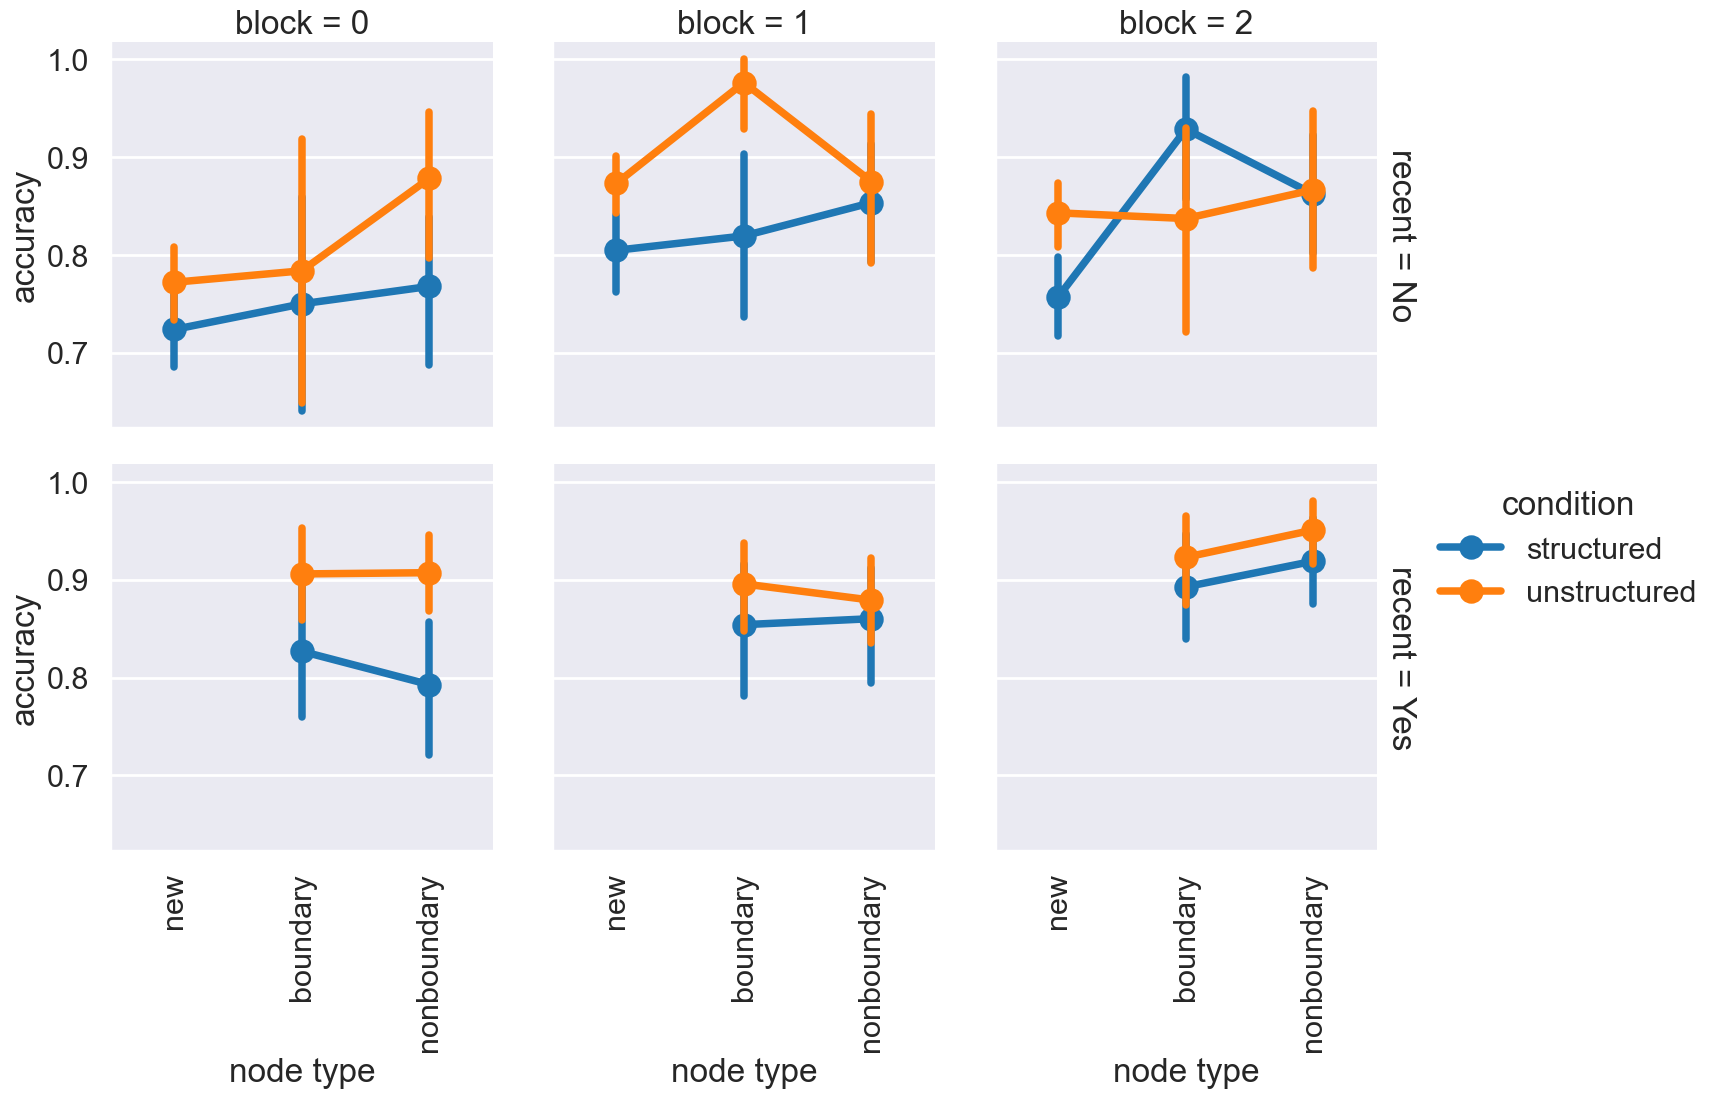

In [81]:
g = sns.catplot(x = 'node type', y = 'accuracy',  
           data = df_clean_memory, kind = 'point', margin_titles=True, order = ['new', 'boundary', 'nonboundary'], row = 'recent',
                col = 'block', hue = 'condition')
g.set_xticklabels(['new', 'boundary', 'nonboundary'], rotation=90)

In [229]:
df_clean_exposure['trial_bins'] = (df_clean_exposure['trials']/150).astype(int)

In [230]:
df_clean_exposure_rt_outlier = df_clean_exposure[np.abs(stat.zscore(df_clean_exposure['rt'], nan_policy='omit')) < 3]


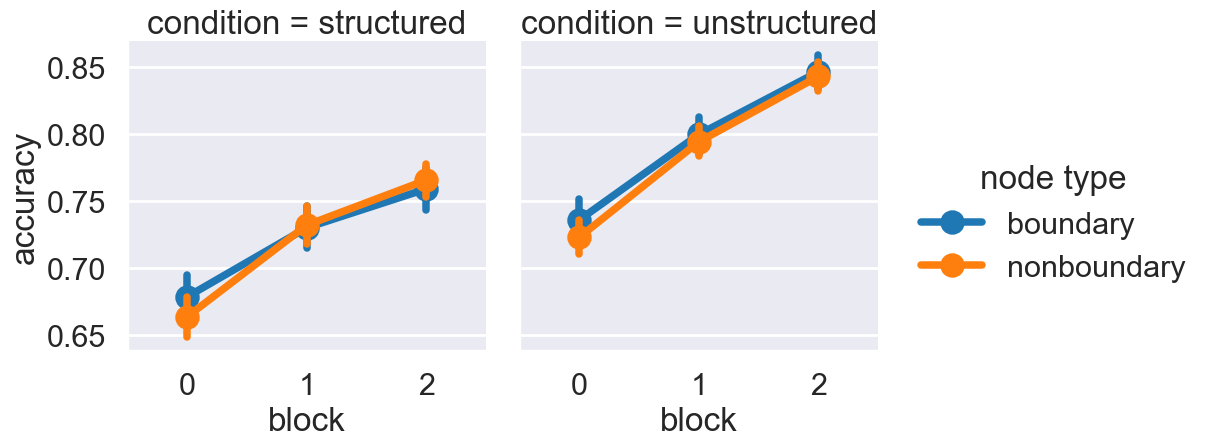

In [48]:
g = sns.catplot(x = 'block', y = 'accuracy',  col = 'condition',
           data = df_clean_exposure, kind = 'point', margin_titles=True, hue = 'node type')
# g.set_xticklabels(rotation=90)

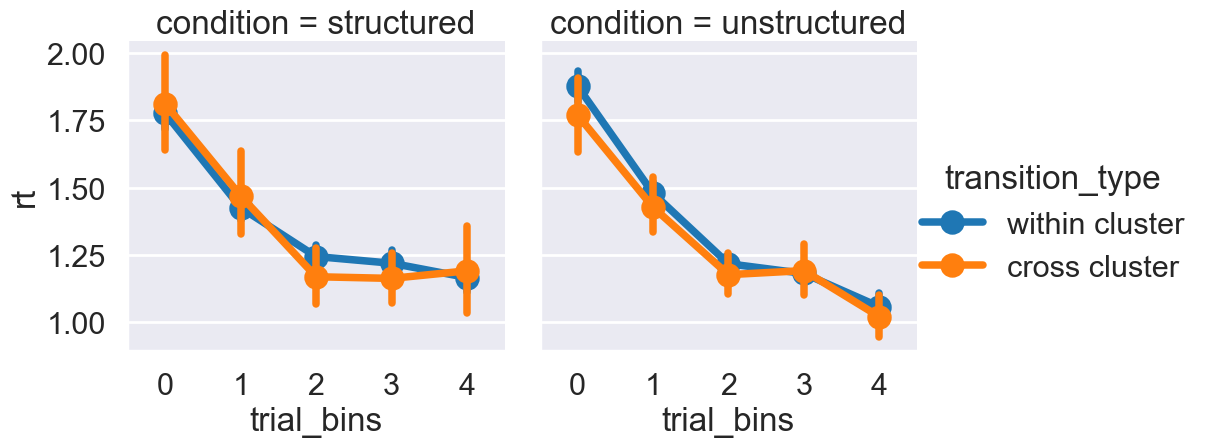

In [231]:
sns.catplot(x = 'trial_bins', y = 'rt',  col = 'condition', estimator='mean',
           data = df_clean_exposure, hue = 'transition_type', kind = 'point')
# g.set_xticklabels(rotation=90)

In [222]:
df_clean_exposure['phase'] = 'exposure'
df_clean_memory['phase'] = 'memory'

In [224]:
concat_df = pd.concat([df_clean_exposure[['rt', 'accuracy', 'condition', 'block', 'node type', 'participant', 'phase']],
df_clean_memory[['rt', 'accuracy', 'condition', 'block', 'node type', 'participant', 'phase']]]).reset_index(drop=True)



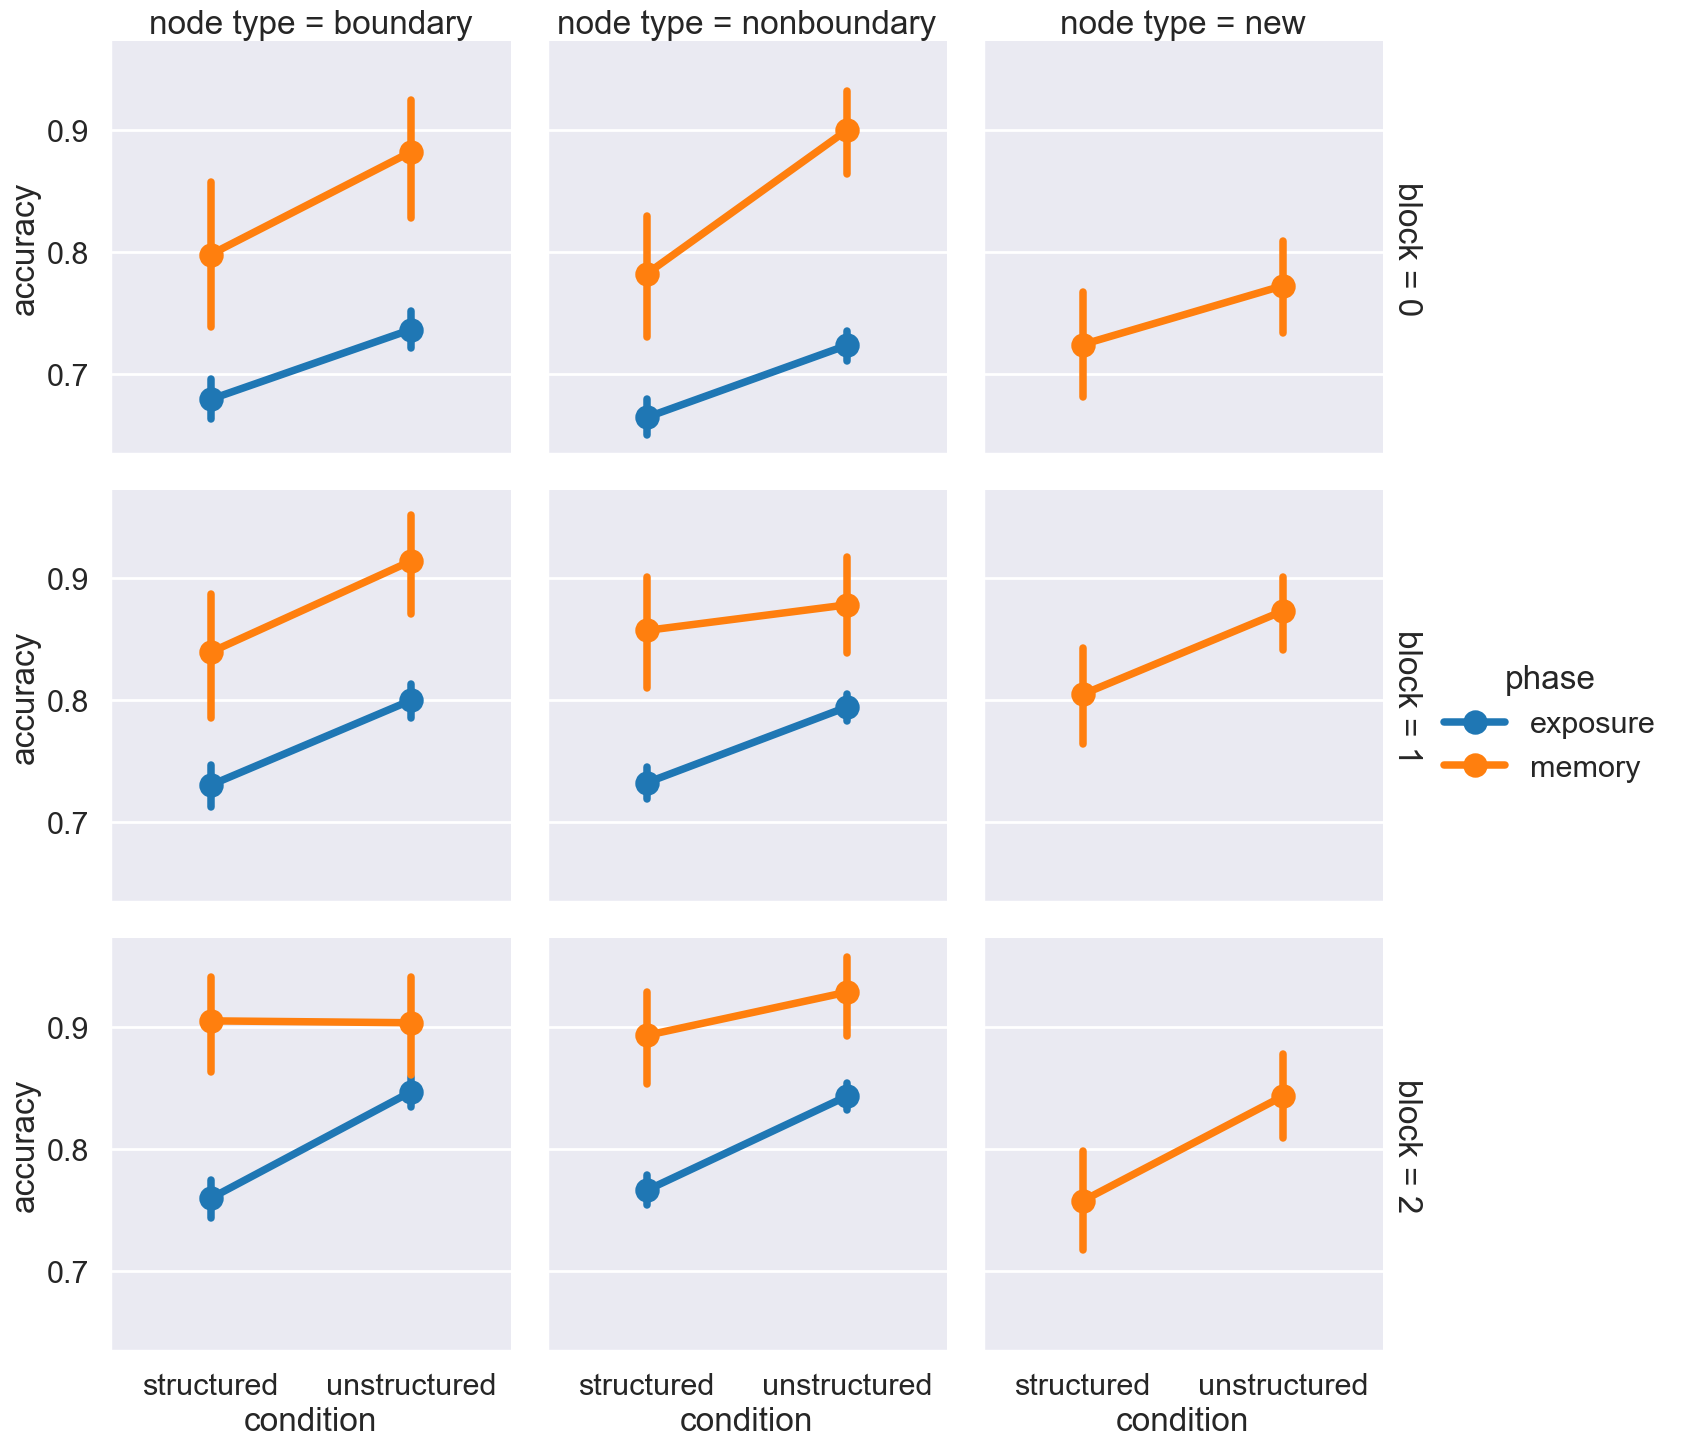

In [226]:
g = sns.catplot(x = 'condition', y = 'accuracy',  col = 'node type', row = 'block',
           data = concat_df, kind = 'point', margin_titles=True, hue = 'phase')

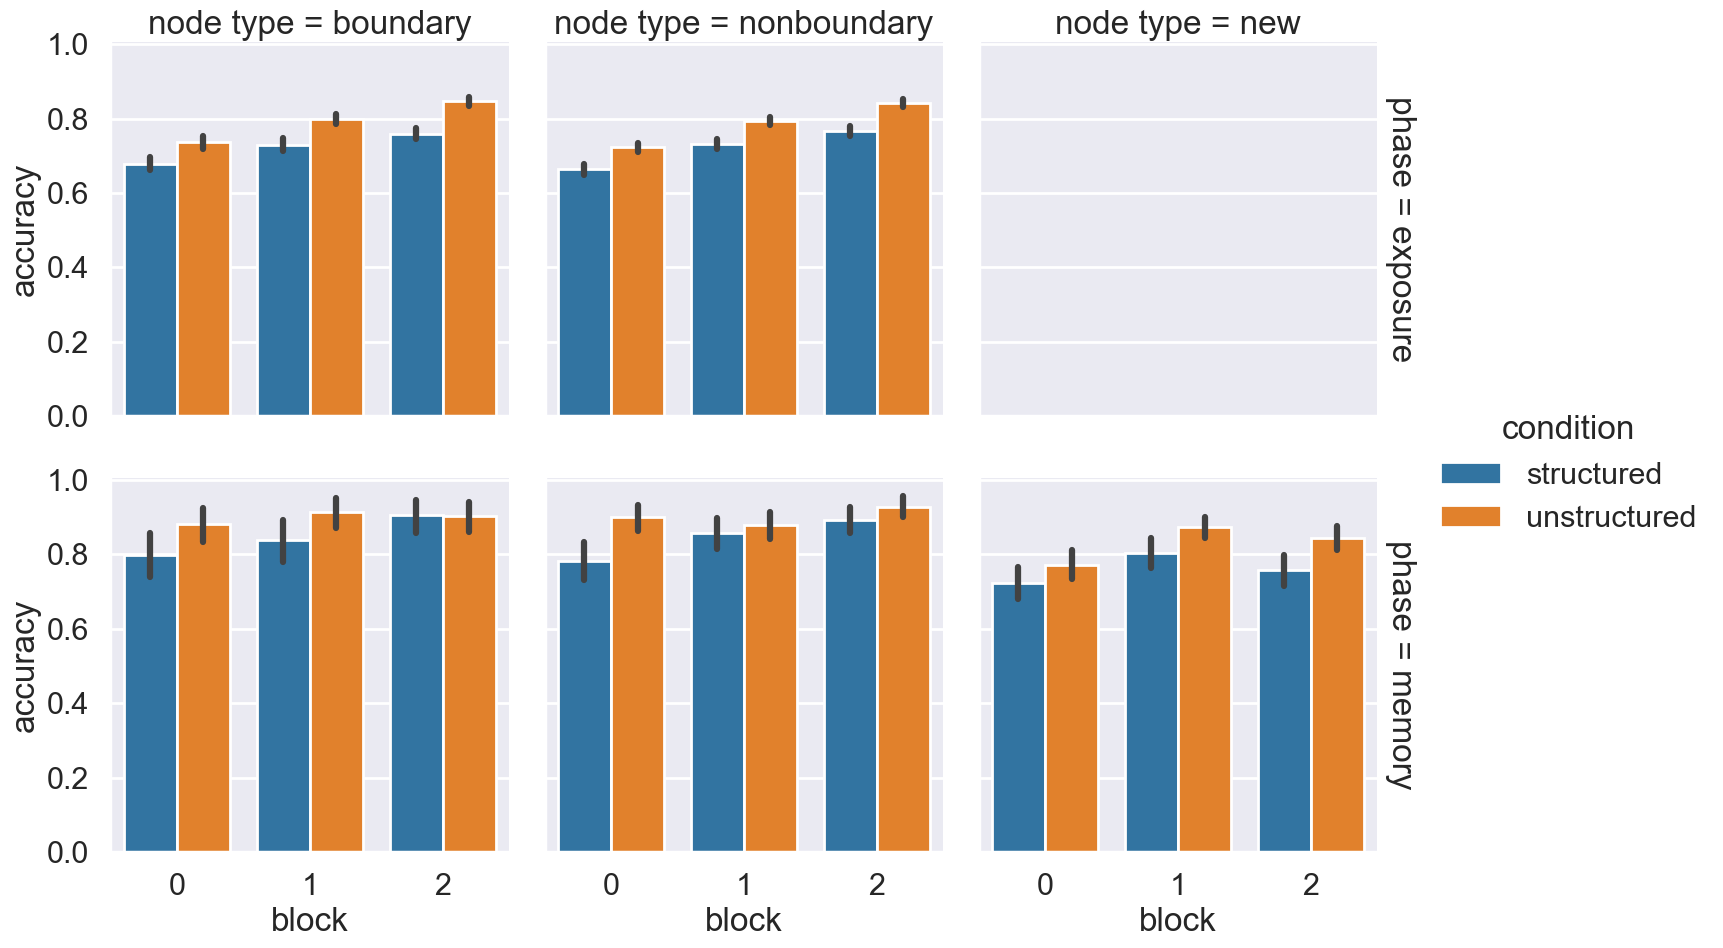

In [74]:
g = sns.catplot(x = 'block', y = 'accuracy',  col = 'node type',
           data = concat_df, kind = 'bar', margin_titles=True, row = 'phase', hue = 'condition')

In [54]:
df_clean = pd.concat([clean_data(f, 'learning') for f in data_files]).reset_index(drop = True)
# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



# df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'graph identity', 'condition', 'test no']).mean(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

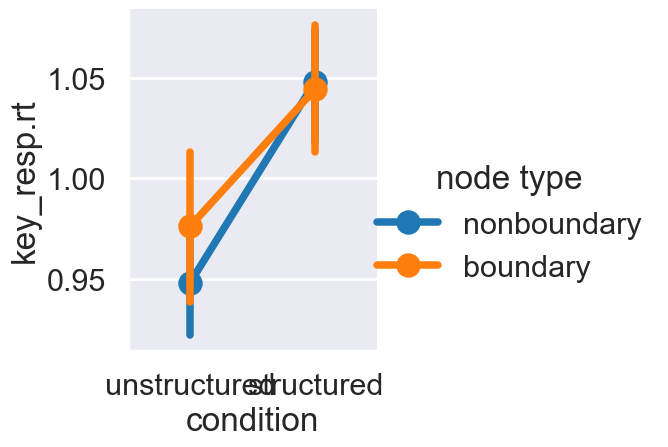

In [58]:
df_clean_memory['resp_old'] = 1
df_clean_memory.loc[((df_clean_memory['old or new'] == 'new') & df_clean_memory.accuracy), 'resp_old'] = 0
df_clean_memory.loc[((df_clean_memory['old or new'] == 'old') & (1 - df_clean_memory.accuracy)), 'resp_old'] = 0


df_clean_memory['true_old'] = 1
df_clean_memory.loc[df_clean_memory['node type'] == 'new', 'true_old'] = 0



In [59]:
df_clean_memory.head(10)

,rt,old or new,accuracy,test item,condition,trials,block,node type,participant,say_old,is_old,resp_old,true_old
0,4.733710,new,1.0,stimuli/244.png,structured,0,0,new,24064.0,0,0,0,0
1,4.043422,old,1.0,stimuli/197.png,structured,1,0,nonboundary,24064.0,1,1,1,1
2,8.199069,new,1.0,stimuli/256.png,structured,2,0,new,24064.0,0,0,0,0
3,1.204968,old,1.0,stimuli/164.png,structured,3,0,nonboundary,24064.0,1,1,1,1
4,1.449138,new,1.0,stimuli/123.png,structured,4,0,new,24064.0,0,0,0,0
5,1.445963,new,0.0,stimuli/2.png,structured,5,0,new,24064.0,1,0,1,0
6,0.749083,old,1.0,stimuli/89.png,structured,6,0,boundary,24064.0,1,1,1,1
7,0.906909,old,1.0,stimuli/50.png,structured,7,0,boundary,24064.0,1,1,1,1
8,0.840770,old,0.0,stimuli/87.png,structured,8,0,nonboundary,24064.0,0,1,0,1
9,1.894965,new,1.0,stimuli/155.png,structured,9,0,new,24064.0,0,0,0,0


In [182]:
df_exposure_acc = df_clean_exposure.groupby(['participant', 'stim chosen', 'block']).mean(numeric_only=True).reset_index()
df_exposure_acc = df_exposure_acc.loc[df_exposure_acc.block == 2].reset_index(drop=True)
df_exposure_acc

,participant,stim chosen,block,trials,path id,rt,accuracy
0,24064.0,stimuli/113.png,2,636.038462,3.0,1.898391,0.615385
1,24064.0,stimuli/12.png,2,600.615385,6.0,1.653783,0.615385
2,24064.0,stimuli/164.png,2,612.266667,11.0,0.956160,0.866667
3,24064.0,stimuli/176.png,2,643.333333,0.0,1.348235,0.761905
4,24064.0,stimuli/197.png,2,638.416667,2.0,2.229863,0.875000
...,...,...,...,...,...,...,...
880,242071.0,stimuli/276.png,2,648.777778,11.0,1.081169,0.555556
881,242071.0,stimuli/3.png,2,584.363636,4.0,0.930134,0.909091
882,242071.0,stimuli/61.png,2,638.192308,7.0,1.213217,0.807692
883,242071.0,stimuli/64.png,2,630.642857,10.0,1.643380,0.500000


In [193]:
df_clean_memory = pd.merge(df_clean_memory, df_exposure_acc[["participant", 'stim chosen', 'accuracy']],  right_on =['participant', 'stim chosen'], left_on = ['participant', 'test item'], how = 'outer')

In [202]:
df_memory_boundary = df_clean_memory.loc[df_clean_memory['node type'] != "nonboundary"].reset_index(drop=True)
df_memory_nonboundary = df_clean_memory.loc[df_clean_memory['node type'] != "boundary"].reset_index(drop=True)

In [203]:
bmb_model_boundary = bmb.Model('resp_old ~  (1|participant) + (0 + true_old|condition)', family='bernoulli', data = df_memory_boundary.loc[df_memory_boundary.block == 2].reset_index(drop=True))

ValueError: 'data' contains 885 incomplete rows.

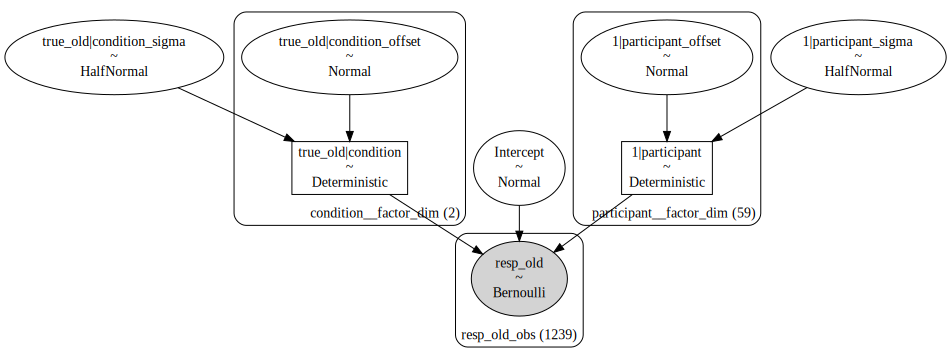

In [168]:
bmb_model_boundary.build()
bmb_model_boundary.graph()

In [169]:
boundary_samples = bmb_model_boundary.fit()

Modeling the probability that resp_old==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|participant_sigma, 1|participant_offset, true_old|condition_sigma, true_old|condition_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 172 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'Boundary d_')

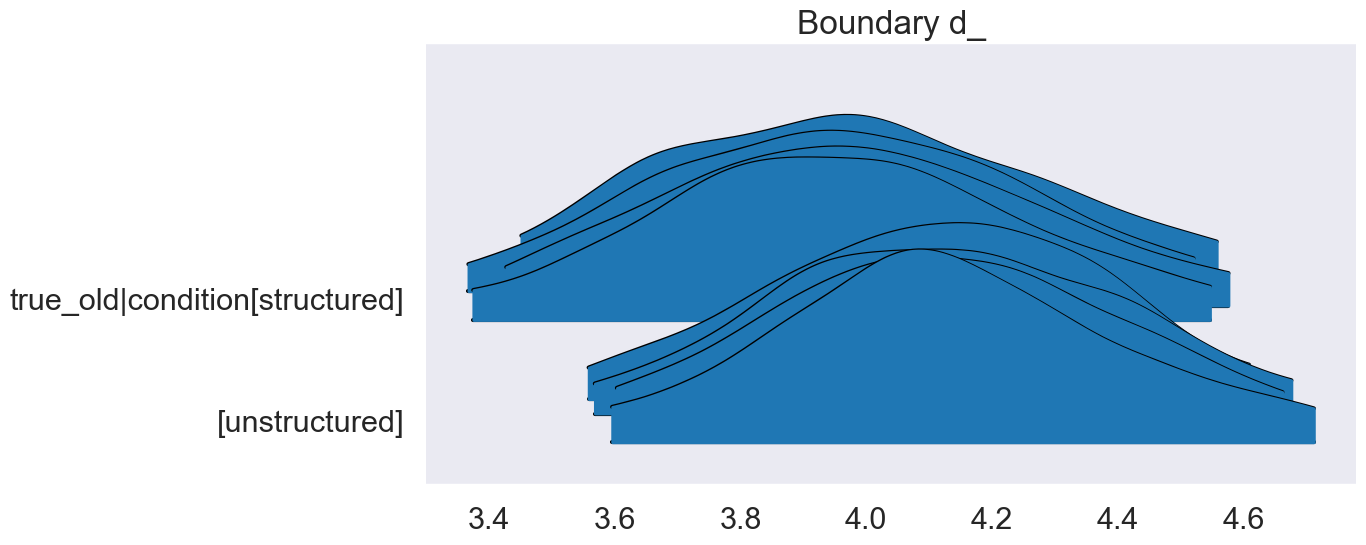

In [214]:
az.plot_forest(boundary_samples, var_names=["true_old|condition"], kind='ridgeplot')
plt.title('Boundary d_')

In [171]:
bmb_model_nonboundary = bmb.Model('resp_old ~  (1|participant) + (0 + true_old|condition)', family='bernoulli', data = df_memory_nonboundary.loc[df_memory_nonboundary.block == 2].reset_index(drop=True))

In [211]:
bmb_model_nonboundary

       Formula: resp_old ~  (1|participant) + (0 + true_old|condition)
        Family: bernoulli
          Link: p = logit
  Observations: 1416
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            1|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
            true_old|condition ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.164))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

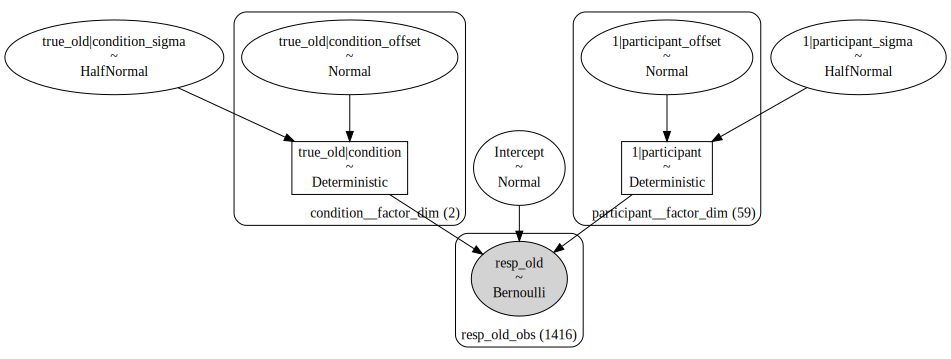

In [172]:
bmb_model_nonboundary.build()
bmb_model_nonboundary.graph()

In [173]:
nonboundary_samples = bmb_model_nonboundary.fit()

Modeling the probability that resp_old==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|participant_sigma, 1|participant_offset, true_old|condition_sigma, true_old|condition_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 235 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'Non Boundary d_')

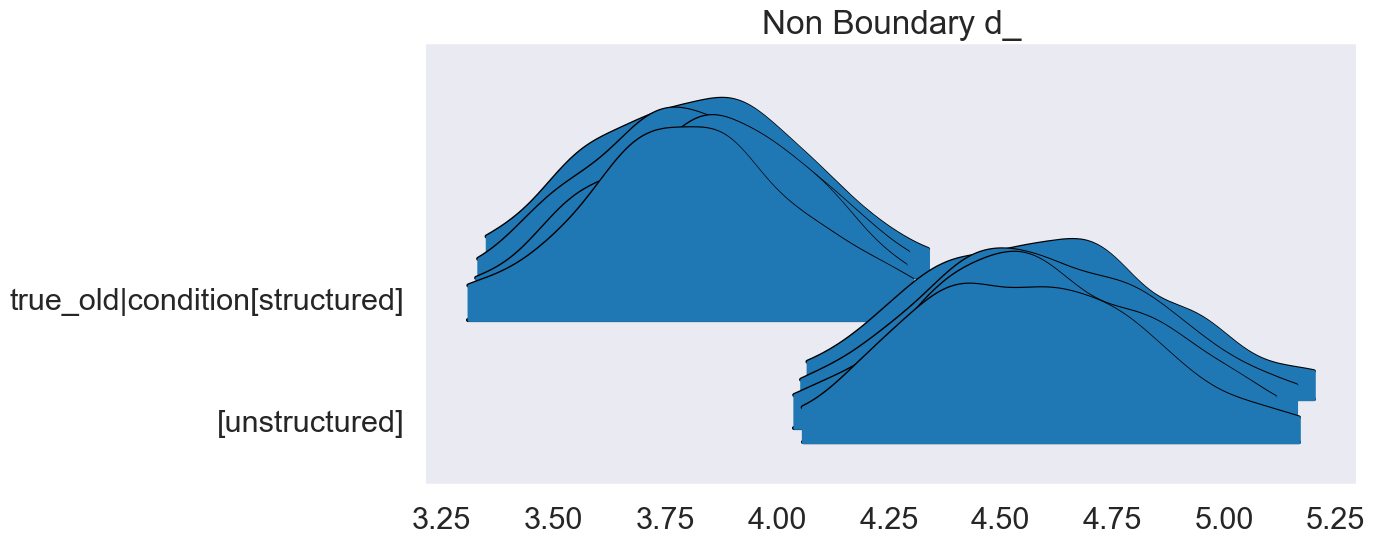

In [213]:
az.plot_forest(nonboundary_samples, var_names=["true_old|condition"], kind = 'ridgeplot')
plt.title('Non Boundary d_')

Text(0.5, 1.0, 'Structured - Unstructured d_')

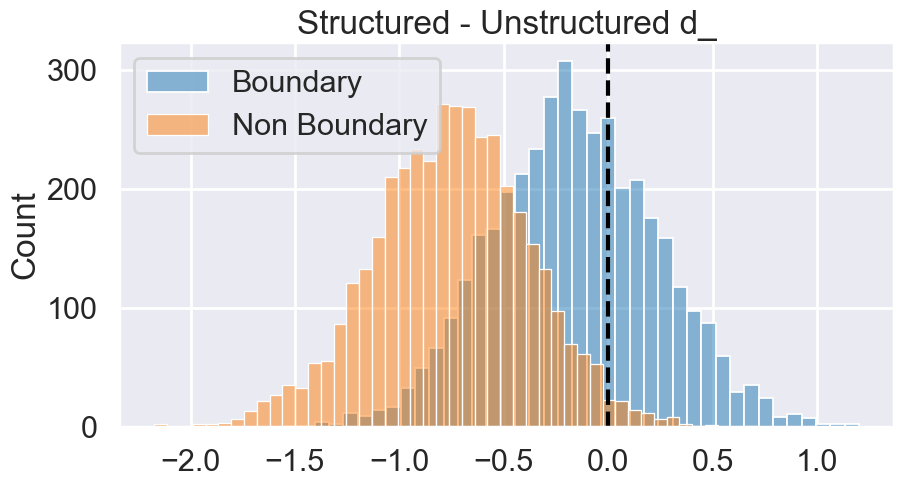

In [175]:
fig, ax = plt.subplots(figsize = (10, 5))
extracted = az.extract(boundary_samples, var_names='true_old|condition')
sns.histplot(extracted[0] - extracted[1], alpha = 0.5, ax = ax, label = 'Boundary')
extracted = az.extract(nonboundary_samples, var_names='true_old|condition')
sns.histplot(extracted[0] - extracted[1], alpha = 0.5, ax = ax, label = 'Non Boundary')
ax.legend()
ax.axvline(x = 0, ls = '--', color = 'black')
ax.set_title('Structured - Unstructured d_')


<Axes: xlabel='resp_old'>

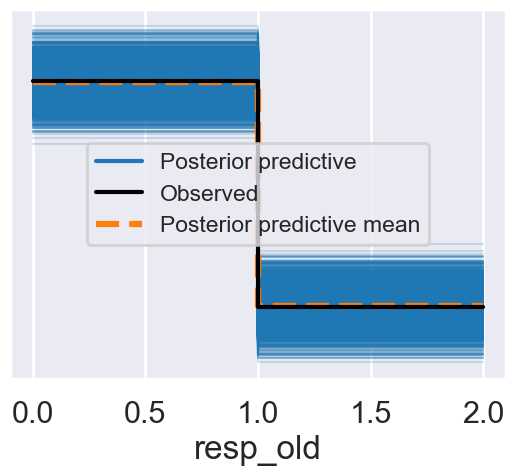

In [209]:
bmb_model_boundary.predict(boundary_samples, kind = 'pps')
az.plot_ppc(boundary_samples)

<Axes: xlabel='resp_old'>

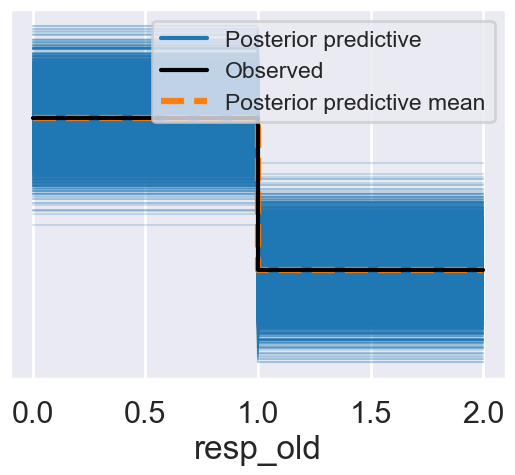

In [210]:
bmb_model_nonboundary.predict(nonboundary_samples, kind = 'pps')
az.plot_ppc(nonboundary_samples)


In [30]:
hssm.set_floatX("float32")


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [31]:
df_clean_memory['response'] = df_clean_memory['accuracy']
df_clean_memory.loc[df_clean_memory.accuracy == 0, 'response'] = -1


In [32]:
ddm_model = hssm.HSSM(data = df_clean_memory[['response', 'rt']])

In [34]:
ddm_model.graph()

TypeError: ModelGraph._make_node() missing 1 required keyword-only argument: 'node_formatters'

In [ ]:
ddm_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, a, z, v]
